# Indroduction
This example demonstrates the application of the `DoWhy` library to analyze causal effects with continuous treatment and multiple outcomes. The code simulates data involving a confounder, continuous treatment, and two outcomes, then applies DoWhy to estimate and validate causal effects for each outcome, since DoWhy only works componentwise.

#### 1. Simulating the Data
The `simulate_data_continuous_multiple_outcomes()` function creates synthetic data:
- A `confounder` is drawn from a normal distribution, affecting both the treatment and outcomes.
- `treatment` is a continuous variable influenced by the confounder, with added noise.
- `outcome1` and `outcome2` are influenced by both `treatment` and the `confounder`, with unique coefficients and noise.

The data is stored in a Pandas DataFrame containing the `Treatment`, two `Outcome` variables, and the `Confounder`.

In [5]:
import numpy as np
import pandas as pd
from dowhy import CausalModel
import warnings
warnings.filterwarnings('ignore')

# Function to simulate data with continuous treatment and multiple outcomes
def simulate_data_continuous_multiple_outcomes(sample_size=10000):
    np.random.seed(2)
    confounder = np.random.normal(0, 1, sample_size)
    # Continuous treatment influenced by confounder
    treatment = 0.5 * confounder + np.random.normal(0, 1, sample_size)
    # Multiple outcomes influenced by treatment and confounder
    outcome1 = 2 * treatment + 3 * confounder + np.random.normal(0, 1, sample_size)
    outcome2 = -1 * treatment + 4 * confounder + np.random.normal(0, 1, sample_size)
    
    data = pd.DataFrame({
        'Treatment': treatment, 
        'Outcome1': outcome1, 
        'Outcome2': outcome2, 
        'Confounder': confounder
    })
    return data

# Create data
data = simulate_data_continuous_multiple_outcomes()

# Display the first few rows of the data
print(data.head())

   Treatment   Outcome1   Outcome2  Confounder
0  -1.016558  -3.302298  -0.801092   -0.416758
1  -0.558159  -1.645103   0.178600   -0.056267
2  -1.358501  -8.890918 -10.115190   -2.136196
3   0.464903   5.141582   6.605666    1.640271
4  -2.861773 -10.011569  -3.902743   -1.793436


#### 2. Causal Analysis for Each Outcome
For each outcome (`Outcome1` and `Outcome2`), the script performs the following:

- **Define a Causal Model**: 
  - A `CausalModel` is defined with the data, specifying `treatment`, the specific `outcome`, and `common_causes` (confounder in this case).
  - The causal graph is visually represented using `model.view_model()` which helps in validating the assumed causal relationships.

- **Identify Causal Effect**:
  - The `identify_effect()` method identifies the causal effect by analyzing the causal graph and determining a formula based on the specified `treatment`, `outcome`, and `common_causes`.

- **Estimate Causal Effect**:
  - The `estimate_effect()` method estimates the treatment effect using linear regression, specified by `method_name="backdoor.linear_regression"`.
  - The estimation accounts for the confounder to provide an unbiased effect of the treatment on the outcome.

- **Refute the Estimate**:
  - The `refute_estimate()` method validates the robustness of the causal estimate using a placebo treatment refuter. This checks if the estimate could arise due to random chance by simulating a placebo treatment and ensuring no significant causal effect is observed.

Analyzing causal effect for Outcome1:



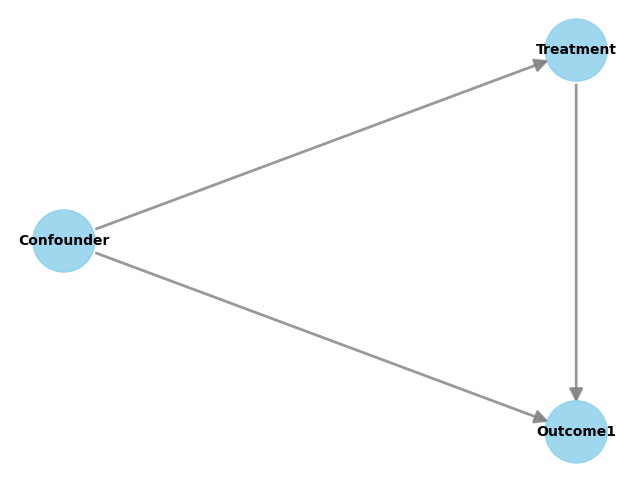

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[Outcome1|Confounder])
d[Treatment]                        
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome1 then P(Outcome1|Treatment,Confounder,U) = P(Outcome1|Treatment,Confounder)

## Realized estimand
b: Outcome1~Treatment+Confounder
Target units: ate

## Estimate
Mean value: 1.9845710184046523

Analyzing causal effect for Outcome2:



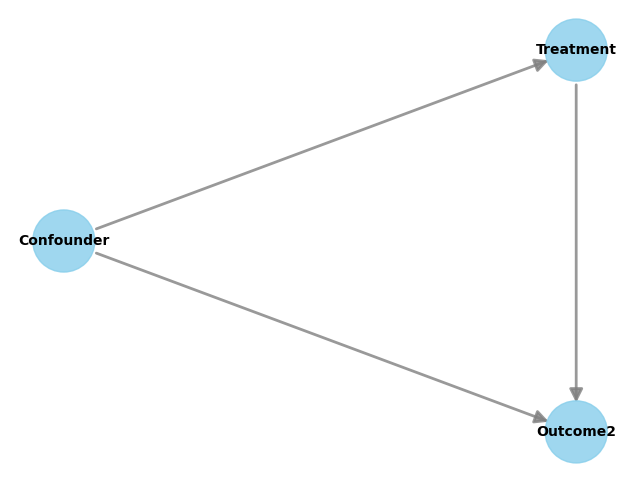

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                              
────────────(E[Outcome2|Confounder])
d[Treatment]                        
Estimand assumption 1, Unconfoundedness: If U→{Treatment} and U→Outcome2 then P(Outcome2|Treatment,Confounder,U) = P(Outcome2|Treatment,Confounder)

## Realized estimand
b: Outcome2~Treatment+Confounder
Target units: ate

## Estimate
Mean value: -0.9893248183250489



In [6]:
# Define and estimate causal effect for each outcome separately
for outcome in ['Outcome1', 'Outcome2']:
    print(f"Analyzing causal effect for {outcome}:\n")

    # Define a causal model for each outcome
    model = CausalModel(
        data=data,
        treatment='Treatment',
        outcome=outcome,
        common_causes=['Confounder']
    )

    # View causal graph
    model.view_model()

    # Identify causal effect
    identified_estimand = model.identify_effect()

    # Estimate causal effect using linear regression
    estimate = model.estimate_effect(identified_estimand,
                                     method_name="backdoor.linear_regression")

    # Print results
    print(estimate)

In [7]:
# Refute the estimate
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter")
print(refutation)

Refute: Use a Placebo Treatment
Estimated effect:-0.9893248183250489
New effect:0.0
p value:1.0



- **Refutation Outcome**: The provided refutation result for the treatment analysis (using a Placebo Treatment Refuter) gives:
  - **Estimated Effect**: approx -0.98, which is the effect size estimated when the placebo treatment is not used.
  - **New Effect**: 0.0, implying the placebo treatment (a hypothetical, random treatment) shows no causal effect.
  - **p-value**: 1.0, indicating the placebo treatment effect is statistically insignificant, suggesting that observed effects during estimation were unlikely due to random chance.

Here is a reference to the interpretation of the [refuters in the DoWhy-Library](https://causalwizard.app/inference/article/bootstrap-refuters-dowhy).